## Preamble

Run these if notebook is in a new environment, otherwise just skip to `Import modules`

#### Boot cell

Skip if `module_update.py` is in same folder as notebook, next cell downloads this file which in turn will download other files.

In [1]:
import dhlab.module_update as mu

In [2]:
from dhlab.module_update import update, css

In [3]:
css()

In [4]:
update('collocations')

Updated file `D:\Documents\GitHub\Oversettelse\collocations.py`

In [5]:
from collocations import dist_coll_urn

# Import modules

Aktiver cellen nedenfor for å få alt til å virke.

In [6]:
import dhlab.nbtext as nb
from IPython.display import HTML
import requests
from bs4 import BeautifulSoup
import pandas as pd

def mods_digibok(urn, kind='marcxml'):
    """find information about serial number urn (or full urn) for books using NB API. 
    Parameter 'kind' is one of mods, marcxml or dublincore """
    
    if not str(urn).startswith('URN'):
        urnstr = "URN:NBN:no-nb_digibok_{urn}".format(urn=urn)
    r = requests.get("https://api.nb.no:443/catalog/v1/metadata/{ident}/{kind}".format(ident=urnstr, kind=kind))
    return r.text

def translator(urn):
    """Finds the translator for a book"""
    item = BeautifulSoup(mods_digibok(urn, kind='mods'), 'lxml')
    trans = []
    navn = item.find_all('name', {'type':'personal'})
    for i in navn:

        try:
            if i.roleterm.text == 'trl':
                trans.append(i.namepart.text)
        except:
            'nn'
    return ';'.join(trans)
    

In [7]:
def categorize(list_of_words):
    proprium = [x for x in list_of_words if x[0].upper() == x[0]]
    other = [x for x in list_of_words if not x in proprium]

    return {'propr':proprium,
           'other': other }

def select_form(w):
    fs = [x.split()[0] for x in nb.word_form(w)]
    if 'verb' in fs:
        res = 'verb'
    elif 'subst' in fs:
        res = 'subst'
    elif len(fs) > 0:
        res = fs[0]
    else:
        res = 'unknown'
    return res

def sort_word_forms(words):
    res = {select_form(w):w for w in words}
    return res

def mdprint(forskjell, cutoff=5):
    categories = categorize(forskjell[forskjell > cutoff].dropna().index)
    forms = {w:select_form(w) for w in categories['other']}
    Grouping = {cat:[word for word in forms if forms[word] == cat] for cat in forms.values()}
    navn = "## Egennavn \n"
    navn += ', '.join(categories['propr'])
    pos = ""
    for cat in Grouping:
        pos += "## " + cat + "\n"
        pos += ', '.join(Grouping[cat]) + "\n"
    mu.printmd(navn)
    mu.printmd(pos)
    return



In [8]:
def wordbags(words, urns):
    url = 'https://api.nb.no/ngram/wordbags'
    if isinstance(words, str):
        return
    if isinstance(words, list):
        words = {w:[w] for w in words}
    r = requests.post(url, json={'wordbags':words, 'urns':urns})
    return r.json()

In [9]:
def word_frequencies(words):
    url = 'https://api.nb.no/ngram/word_frequencies'
    if isinstance(words, str):
        words = words.split()
    r = requests.post(url, json={'words':words})
    return r.json()

In [10]:
nb.word_paradigm('spisende')

[['adj', ['spisende', 'spist', 'spiste']],
 ['verb', ['spis', 'spise', 'spiser', 'spises', 'spist', 'spiste']]]

## Build corpus

A corpus definition is a set of URNs. Those can be obtained in various ways and stored as text or in MS-Word file.


### Define using metadata 

Lag korpus manuelt, fra excel eller andre kilder. Bare lim inn definisjonen mellom de triple """ """ under

In [13]:
korpus = nb.book_corpus(ddk="8%", trans='eng', period=(1970, 1990), limit=300)
len(korpus)

300

In [14]:
korpus_nob = nb.book_corpus(trans='', lang='nob', ddk="8%", period=(1970, 1990), limit=300)

# Henter bøkene med ord

Her defineres korpuset som en liste over bøker, med informasjon om oversettere. Er korpuset stort (flere hundre) vil det ta noen minutter å hente alle oversetterne, så det kan være lurt å kutte ned størrelsen litt. Inntil vi får på plass en rask måte å gjøre det på, får det her duge. Det er bare å smøre seg med tålmodighet.

## Search corpus for concordances

In [15]:
from random import sample

In [21]:
nb.urn_concordance(word='leende', urns= sample(nb.pure_urn(korpus), 50))

"Mitt navn er Asher Lev, Potok, Chaim, 1990",som spaserte . Jeg tegnet,leende,og gråtende barneansikter . Jeg
"levende Frankenstein, Aldiss, Brian W., 1977",". Hun sa , halvveis",leende,: « De må ha
"Kontakt, Sagan, Carl, 1986",Ellie og Joss fikk,leende,kulen til å henge praktisk
"Prinsessen med gullhåret, Wilson, Edmund, 1979",den gammeldagse amerikanske piken med,leende,"øyne , sunn og freidig"
"Mrs. Harris drar til Paris ; og Mrs. Harris drar til New York, Gallico, Paul, 1979","den myke , utsøkte ,",leende,"Natasha og den blonde ,"
"Der veien slutter, Shute, Nevil, 1984","ja , » sa jeg",leende,. « De aner ikke
"Christinas hus, Haas, Ben, 1978","ganske alminnelige , glade ,",leende,unge menn fulle av øl
"Vendepunktet, Godwin, Gail, 1986","meg , » sa hun",leende,", « men skjønnheter fra"
"Vendepunktet, Godwin, Gail, 1986","sa , » svarte mor",leende,". « Du skjønner ,"
"Vendepunktet, Godwin, Gail, 1986","skjøt opp av vannet ,",leende,og spyttende . « Jeg
"Chatterton, Ackroyd, Peter, 1989",forsiktig over ham og løp,leende,til døren . Edward holdt


# Definer teksten

Hen teksten - kan ta noe minutter. Kan lagres for senere bruk.

In [23]:
TEXT = nb.get_corpus_text(nb.pure_urn(korpus))

with open ('korpus_file_1980.csv','w',encoding="utf-8") as f:
    TEXT.to_csv(path_or_buf=f)

TEXT_NOB = nb.get_corpus_text(nb.pure_urn(korpus_nob))

with open ('korpus_file_nob_1980.csv','w',encoding="utf-8") as f:
    TEXT_NOB.to_csv(path_or_buf=f)

In [15]:
TEXT = pd.read_csv("korpus_file_1980.csv", index_col = 0)
TEXT_NOB = pd.read_csv("korpus_file_nob_1980.csv", index_col = 0)

In [24]:
from collections import Counter
word = 'ikke'
a = dict(nb.word_paradigm(word))
res = dict()
for cat in a:
    res[(cat, word)] = sum(Counter(dict(word_frequencies(a[cat]))).values())
res        

{('adv', 'ikke'): 137898651, ('subs', 'ikke'): 137905044}

In [25]:
nb.word_paradigm('ikke')

[['adv', ['ikke']], ['subs', ['ikke', 'ikken', 'ikkene', 'ikker']]]

In [16]:

TEXT_NOB = pd.read_csv('korpus_file_nob.csv', index_col=0)

#### convertet to md
import pandas as pd
with open ('korpus_file.csv','r', encoding="utf-8") as f:
    text = pd.read_csv(f)

In [26]:
TEXT.sort_values(by=TEXT.columns[0], ascending=False)[:10]

,2013031206018,2013040507021,2011012105050,2015082548139,2012071806015,2012022908075,2016030907022,2012062806124,2009092900105,2013012907209,...,2015072108291,2012012008059,2011110208183,2010101208095,2011022320087,2014032406004,2015102308102,2016062748040,2014103008108,2013060708127
",",1717.0,3488.0,556.0,4515.0,46.0,3314.0,2644.0,6094.0,1519.0,3022.0,...,4557.0,77.0,12.0,90.0,1744.0,3826.0,6422.0,3996.0,3368.0,4342.0
.,1713.0,9025.0,914.0,8095.0,61.0,5714.0,3384.0,7673.0,2577.0,4247.0,...,4059.0,241.0,30.0,247.0,2640.0,4929.0,7894.0,5459.0,2423.0,5566.0
«,1000.0,24.0,655.0,200.0,1.0,1325.0,73.0,1745.0,1402.0,7.0,...,1277.0,NaN,2.0,46.0,4.0,122.0,184.0,2124.0,55.0,1740.0
»,971.0,23.0,634.0,183.0,6.0,1380.0,72.0,1720.0,1373.0,7.0,...,1262.0,NaN,1.0,56.0,21.0,119.0,170.0,2089.0,54.0,1718.0
det,829.0,2265.0,242.0,1925.0,9.0,1552.0,1237.0,2531.0,530.0,838.0,...,1518.0,33.0,2.0,40.0,615.0,1390.0,1531.0,1908.0,742.0,1957.0
og,788.0,2863.0,283.0,2822.0,16.0,1646.0,1709.0,4119.0,747.0,1633.0,...,2508.0,47.0,3.0,73.0,690.0,2268.0,5462.0,3180.0,1436.0,2435.0
er,584.0,1181.0,254.0,1319.0,7.0,433.0,518.0,1510.0,399.0,385.0,...,759.0,12.0,4.0,5.0,419.0,529.0,738.0,1056.0,441.0,1094.0
å,507.0,1718.0,152.0,1003.0,2.0,1162.0,844.0,1571.0,624.0,717.0,...,992.0,17.0,NaN,28.0,415.0,1252.0,1684.0,1222.0,870.0,1464.0
som,432.0,1140.0,82.0,1131.0,4.0,1234.0,537.0,1674.0,277.0,678.0,...,1028.0,16.0,2.0,28.0,281.0,1094.0,2150.0,1189.0,967.0,916.0
en,415.0,1351.0,155.0,1484.0,4.0,1174.0,715.0,2014.0,320.0,835.0,...,1168.0,NaN,4.0,31.0,456.0,1330.0,1609.0,1205.0,787.0,1144.0


### Starter med listen over mulige partisipper

In [27]:
TEXT.index = TEXT.index.map(str)

In [28]:
poss_part = list ({x for x in TEXT.index if x.endswith('ende')})

In [29]:
TEXT.index

Index([',', '.', '«', '»', 'det', 'og', 'er', 'å', 'som', 'en',
       ...
       '„sefæle-ting"', '•', '€', '™', '□', '►', '▼', '★', '♦', '✓'],
      dtype='object', length=399600)

### Henter ut de 100 mest frekvente

In [30]:
N = 200
test_words = list(TEXT.loc[TEXT.index.str.contains(".*ende")].sum(axis=1).sort_values(ascending=False)[:N].index)

In [31]:
variants = dict()
for w in test_words:
    variants[w] = nb.word_paradigm(w)

In [32]:
forms = dict()
for w in test_words:
    forms[w] = nb.word_form(w)

In [33]:
nb.frame(variants)

,0,1,2,3
hendene,"[subs, [henda, hende, hendene, hender, hendet,...",None,None,None
stående,"[adj, [stående, stått, ståtte]]","[verb, [sto, stod, stå, ståes, står, stås, stå...",None,None
hender,"[adj, [hendende, hendt, hendte]]","[subs, [henda, hende, hendene, hender, hendet,...","[verb, [hend, hende, hender, hendes, hendt, he...",None
endelig,"[adj, [endelig, endelige, endeligere, endeligs...",None,None,None
enden,"[subs, [ende, enden, endene, ender]]",None,None,None
sende,"[adj, [sendende, sendt, sendte]]","[verb, [send, sende, sender, sendes, sendt, se...",None,None
rasende,"[adj, [rasa, rasende, rast, raste]]","[adv, [rasende]]","[verb, [ras, rasa, rase, raser, rases, rast, r...",None
sittende,"[adj, [sitne, sitten, sittende, sittet]]","[verb, [satt, sitt, sitte, sitter, sittes, sit...",None,None
levende,"[adj, [levd, levde, levede, levende, levet, le...","[verb, [lev, levd, levde, leve, lever, leves, ...",None,None
hende,"[adj, [hendende, hendt, hendte, hende]]","[subs, [henda, hende, hendene, hender, hendet]]","[verb, [hend, hende, hender, hendes, hendt, he...",None


## Velg former

Plukk ut partisippformene, dersom formen opptrer både som adjektiv og som verb, ellers ut. Nedenfor plukkes ut de alternative verbformene som kan sammenlignes med partisippen.

Her benyttes en enkelt heuristikk. Partisippformen må være oppført både som et adjektiv og et verb, i tillegg må ikke formen selv være blandt verbene.

In [34]:
participles = dict()
for w in variants:
    # finn POS for alle variantene
    kinds = [x[0] for x in variants[w]]
    
    # sjekk at både adj og verb er blant dem
    if 'adj' and 'verb' in kinds:
        
        # Ta ut de som har formen blant verbene (partisippet er ikke verd i NO)
        F = [k[1] for k in variants[w] if k[0] == 'verb' and not w in k[1] ]
        if F != []:
            participles[w] = F

## Se på resultatet

In [35]:
participles

{'stående': [['sto', 'stod', 'stå', 'ståes', 'står', 'stås', 'stått']],
 'rasende': [['ras', 'rasa', 'rase', 'raser', 'rases', 'rast', 'raste']],
 'sittende': [['satt', 'sitt', 'sitte', 'sitter', 'sittes', 'sittet']],
 'levende': [['lev', 'levd', 'levde', 'leve', 'lever', 'leves', 'levet']],
 'liggende': [['ligg', 'ligge', 'ligger', 'ligges', 'ligget', 'lå', 'låg']],
 'strålende': [['strål', 'stråle', 'stråler', 'stråles', 'strålt', 'strålte']],
 'skinnende': [['skein',
   'skinn',
   'skinne',
   'skinner',
   'skinnes',
   'skint',
   'skinte']],
 'smilende': [['smil', 'smile', 'smiler', 'smiles', 'smilt', 'smilte']],
 'skjelvende': [['skalv',
   'skjelv',
   'skjelve',
   'skjelver',
   'skjelves',
   'skjelvet']],
 'spennende': [['spenn', 'spenne', 'spenner', 'spennes', 'spent', 'spente']],
 'utseende': [['utse', 'utsees', 'utser', 'utses', 'utsett', 'utså', 'utsåg']],
 'hengende': [['heng',
   'henge',
   'henger',
   'henges',
   'hengt',
   'hengte',
   'hang']],
 'gående': [['g

Nå lager vi en ny statistikk der alle ordene telles opp fra datarammen for sammenligning

In [36]:
counts = dict()
for w in participles:
    counts[w] = max(1, TEXT.loc[list(set(participles[w][0]) & set(TEXT.index))].sum(axis=1).sum())

In [37]:
counts_nob = dict()
for w in participles:
    counts_nob[w] = max(1, TEXT_NOB.loc[list(set(participles[w][0]) & set(TEXT_NOB.index))].sum(axis=1).sum())

In [38]:
counts_nob

{'stående': 28259.0,
 'rasende': 743.0,
 'sittende': 29748.0,
 'levende': 5685.0,
 'liggende': 17147.0,
 'strålende': 442.0,
 'skinnende': 1289.0,
 'smilende': 6607.0,
 'skjelvende': 1222.0,
 'spennende': 1271.0,
 'utseende': 19.0,
 'hengende': 4227.0,
 'gående': 53923.0,
 'truende': 2111.0,
 'skremmende': 1273.0,
 'løpende': 4916.0,
 'passende': 3086.0,
 'lignende': 1398.0,
 'beroligende': 196.0,
 'brennende': 2171.0,
 'spørrende': 11392.0,
 'vedkommende': 78.0,
 'flytende': 996.0,
 'tiltrekkende': 146.0,
 'triumferende': 64.0,
 'glitrende': 298.0,
 'følgende': 7106.0,
 'overraskende': 591.0,
 'nølende': 603.0,
 'imponerende': 201.0,
 'sjarmerende': 20.0,
 'lysende': 8859.0,
 'utelukkende': 126.0,
 'oppmuntrende': 127.0,
 'glødende': 385.0,
 'døende': 6357.0,
 'forbausende': 638.0,
 'avgjørende': 538.0,
 'besøkende': 1703.0,
 'forbløffende': 136.0,
 'overbevisende': 560.0,
 'overveldende': 160.0,
 'skingrende': 52.0,
 'glimrende': 23.0,
 'overlevende': 450.0,
 'omgående': 151.0,
 'utf

In [39]:
counts

{'stående': 31682.0,
 'rasende': 1241.0,
 'sittende': 34494.0,
 'levende': 5363.0,
 'liggende': 18761.0,
 'strålende': 576.0,
 'skinnende': 1607.0,
 'smilende': 12658.0,
 'skjelvende': 2257.0,
 'spennende': 1320.0,
 'utseende': 37.0,
 'hengende': 4935.0,
 'gående': 81579.0,
 'truende': 1365.0,
 'skremmende': 2025.0,
 'løpende': 9133.0,
 'passende': 4864.0,
 'lignende': 1769.0,
 'beroligende': 469.0,
 'brennende': 2348.0,
 'spørrende': 22887.0,
 'vedkommende': 88.0,
 'flytende': 939.0,
 'tiltrekkende': 384.0,
 'triumferende': 72.0,
 'glitrende': 441.0,
 'følgende': 10605.0,
 'overraskende': 1625.0,
 'nølende': 1697.0,
 'imponerende': 530.0,
 'sjarmerende': 53.0,
 'lysende': 10810.0,
 'utelukkende': 188.0,
 'oppmuntrende': 416.0,
 'glødende': 614.0,
 'døende': 8881.0,
 'forbausende': 1856.0,
 'avgjørende': 1150.0,
 'besøkende': 3185.0,
 'forbløffende': 688.0,
 'overbevisende': 1845.0,
 'overveldende': 333.0,
 'skingrende': 76.0,
 'glimrende': 15.0,
 'overlevende': 881.0,
 'omgående': 248

# Legg til opptellinger for partisippene

In [40]:
count_frame = {x: {'verb_paradigm': counts[x], 'participle': TEXT.loc[x].sum()} for x in counts}

In [41]:
count_frame_nob = {x: {'verb_paradigm': counts_nob[x], 'participle': TEXT_NOB.loc[x].sum()} for x in counts_nob}

In [42]:
count_frame

{'stående': {'verb_paradigm': 31682.0, 'participle': 3063.0},
 'rasende': {'verb_paradigm': 1241.0, 'participle': 1973.0},
 'sittende': {'verb_paradigm': 34494.0, 'participle': 1823.0},
 'levende': {'verb_paradigm': 5363.0, 'participle': 1599.0},
 'liggende': {'verb_paradigm': 18761.0, 'participle': 1259.0},
 'strålende': {'verb_paradigm': 576.0, 'participle': 1080.0},
 'skinnende': {'verb_paradigm': 1607.0, 'participle': 839.0},
 'smilende': {'verb_paradigm': 12658.0, 'participle': 809.0},
 'skjelvende': {'verb_paradigm': 2257.0, 'participle': 804.0},
 'spennende': {'verb_paradigm': 1320.0, 'participle': 799.0},
 'utseende': {'verb_paradigm': 37.0, 'participle': 751.0},
 'hengende': {'verb_paradigm': 4935.0, 'participle': 707.0},
 'gående': {'verb_paradigm': 81579.0, 'participle': 693.0},
 'truende': {'verb_paradigm': 1365.0, 'participle': 608.0},
 'skremmende': {'verb_paradigm': 2025.0, 'participle': 607.0},
 'løpende': {'verb_paradigm': 9133.0, 'participle': 600.0},
 'passende': {'v

In [43]:
COUNTS = nb.frame(count_frame)

In [44]:
COUNTS.head()

,verb_paradigm,participle
advarende,869.0,239.0
anerkjennende,141.0,143.0
angående,679.0,241.0
anklagende,510.0,128.0
anstrengende,648.0,147.0


In [45]:
COUNTS_NOB = nb.frame(count_frame_nob)

In [46]:
COUNTS_NOB.head()

,verb_paradigm,participle
advarende,277.0,95.0
anerkjennende,181.0,86.0
angående,465.0,88.0
anklagende,264.0,57.0
anstrengende,269.0,85.0


In [47]:
TOT = nb.totals(50000)

In [48]:
TOT = nb.frame(TOT)

Legg til en kolonne med ratioen melllom de to første. 

In [49]:
COUNTS['ratio'] = COUNTS['participle']/(COUNTS['participle']+COUNTS['verb_paradigm'])

In [50]:
COUNTS_NOB['ratio'] = COUNTS_NOB['participle']/(COUNTS_NOB['participle']+COUNTS_NOB['verb_paradigm'])

# Sortér på ratio

Her ser vi klart at det kanskje ikke er ekte partisipper på topp, mer typiske ord i partisippform.

De mest interessante ordene (tror jeg) er på bunnen her, som 'smilende', 'løpende', 'liggende', 'spørrende'. Og den ratioen kan sammenlignes med norsk sett.

In [51]:
COUNTS.sort_values(by='ratio', ascending=False)

,verb_paradigm,participle,ratio
utseende,37.0,751.0,0.953046
glimrende,15.0,288.0,0.950495
gjennomtrengende,12.0,195.0,0.942029
sjarmerende,53.0,375.0,0.876168
misbilligende,24.0,144.0,0.857143
triumferende,72.0,398.0,0.846809
vedkommende,88.0,441.0,0.833648
skingrende,76.0,289.0,0.791781
foruroligende,45.0,164.0,0.784689
tilsvarende,52.0,188.0,0.783333


In [52]:
COUNTS_NOB.sort_values(by='ratio', ascending=False)

,verb_paradigm,participle,ratio
utseende,19.0,254.0,0.930403
misbilligende,7.0,36.0,0.837209
glimrende,23.0,106.0,0.821705
sjarmerende,20.0,81.0,0.801980
vedkommende,78.0,275.0,0.779037
nedlatende,24.0,75.0,0.757576
skingrende,52.0,159.0,0.753555
foruroligende,21.0,63.0,0.750000
tilsvarende,68.0,200.0,0.746269
gjennomtrengende,37.0,95.0,0.719697


# Sammenligner ratio for oversatt mot NOB

In [53]:
COMP = COUNTS['ratio']/COUNTS_NOB['ratio']

In [54]:
HTML(nb.frame(COMP.sort_values(ascending=False)).to_html())

,ratio
fremstående,3.846900
verkende,3.568349
overlevende,2.461255
bydende,2.428441
besøkende,2.071786
tiltalende,1.914729
flytende,1.909213
gapende,1.871601
skurrende,1.861514
truende,1.857032


In [68]:
COUNTS['participle'].loc['verkende']

131.0

In [73]:
COUNTS_NOB['participle'].loc['verkende']

102.0

In [71]:
TEXT_NOB.sum(axis=1).sum()

15782804.0

In [72]:
TEXT.sum(axis=1).sum()

23159290.0

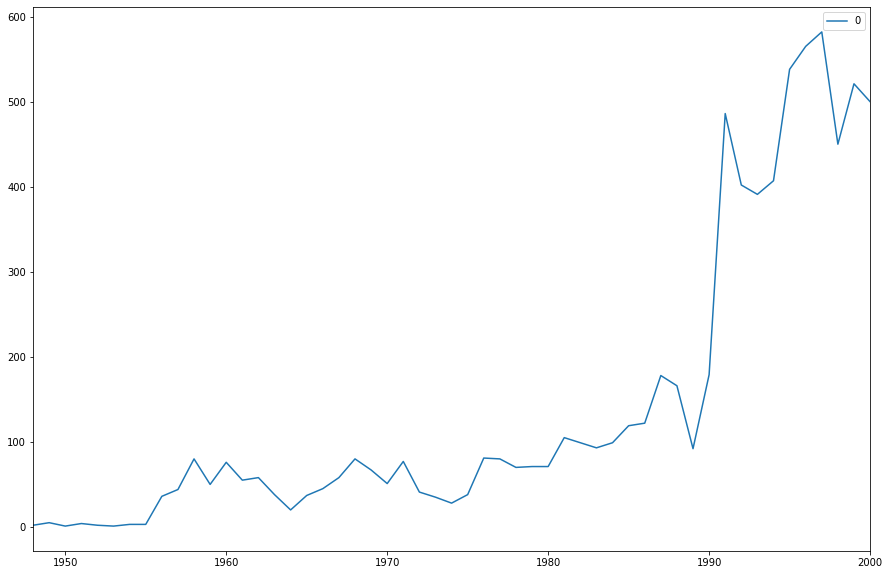

In [75]:
nb.unigram('verkende', ddk="8%", trans='eng', period=(1945, 2000)).plot()

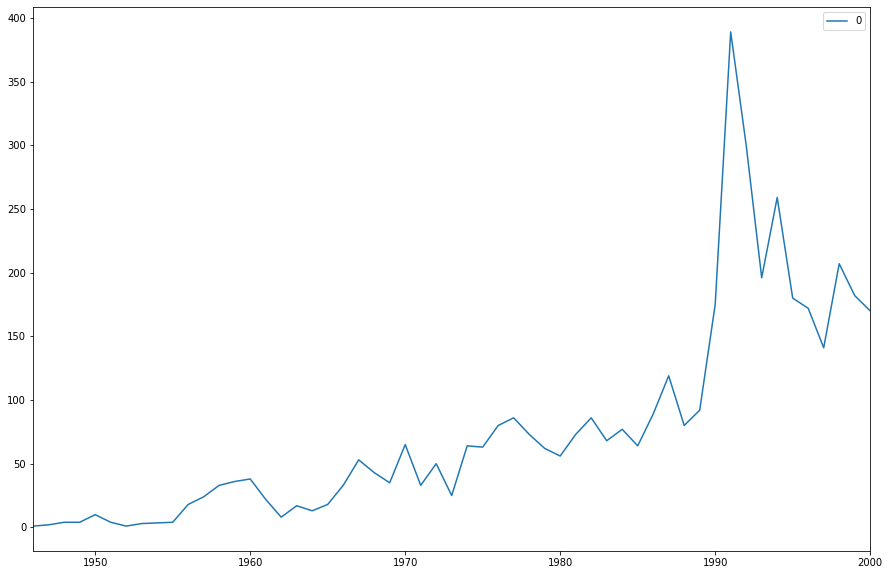

In [74]:
nb.unigram('verkende', ddk="8%", trans='', period=(1945, 2000)).plot()

In [76]:
counts_tot = dict()
for w in participles:
    counts_tot[w] = max(1, TOT.loc[list(set(participles[w][0]) & set(TOT.index))].sum(axis=1).sum())

In [77]:
counts_tot

{'stående': 19437983,
 'rasende': 635995,
 'sittende': 19514023,
 'levende': 5312408,
 'liggende': 14864068,
 'strålende': 323529,
 'skinnende': 864480,
 'smilende': 3740043,
 'skjelvende': 683719,
 'spennende': 751509,
 'utseende': 73206,
 'hengende': 2623103,
 'gående': 39842605,
 'truende': 2250953,
 'skremmende': 643472,
 'løpende': 4492046,
 'passende': 3018854,
 'lignende': 1124850,
 'beroligende': 161135,
 'brennende': 1559790,
 'spørrende': 7493284,
 'vedkommende': 67666,
 'flytende': 644943,
 'tiltrekkende': 202167,
 'triumferende': 1,
 'glitrende': 131025,
 'følgende': 8535735,
 'overraskende': 561859,
 'nølende': 385535,
 'imponerende': 200342,
 'sjarmerende': 1,
 'lysende': 5765415,
 'utelukkende': 329885,
 'oppmuntrende': 242364,
 'glødende': 214013,
 'døende': 4840940,
 'forbausende': 400348,
 'avgjørende': 1212211,
 'besøkende': 1711432,
 'forbløffende': 123009,
 'overbevisende': 674140,
 'overveldende': 91829,
 'skingrende': 1,
 'glimrende': 1,
 'overlevende': 539336,
 

In [78]:
count_frame_tot = {x: {'verb_paradigm': counts_tot[x], 'participle': TOT.loc[x].sum()} for x in counts_tot if x in TOT.index}

In [79]:
TOTCOUNT = nb.frame(count_frame_tot)

In [80]:
TOTCOUNT

,verb_paradigm,participle
advarende,336853,66111
anerkjennende,361350,46021
angående,572794,267385
anklagende,289970,36067
anstrengende,247621,72006
avgjørende,1212211,1008752
bebreidende,122541,42515
bedende,4314613,62088
beroligende,161135,171112
beskyttende,935404,101438


In [81]:
TOTCOUNT['ratio'] = TOTCOUNT['participle']/(TOTCOUNT['participle']+TOTCOUNT['verb_paradigm'])

In [82]:
TOTCOUNT.sort_values(by='ratio', ascending=False)

,verb_paradigm,participle,ratio
glimrende,1,185539,0.999995
sjarmerende,1,103095,0.999990
triumferende,1,96177,0.999990
skingrende,1,70651,0.999986
gjennomtrengende,1,53225,0.999981
nedlatende,1,51633,0.999981
foruroligende,1,48308,0.999979
fortryllende,1,40939,0.999976
misbilligende,1,27242,0.999963
skurrende,1,22798,0.999956


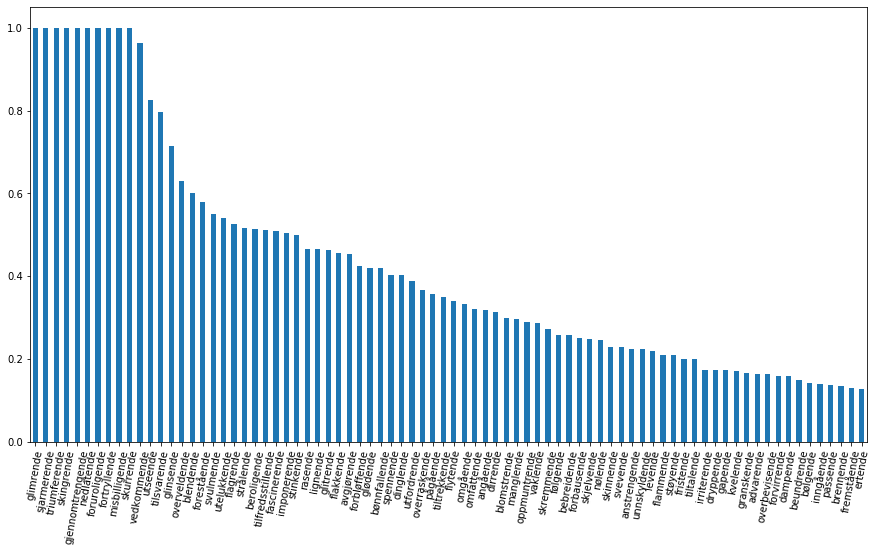

In [85]:
TOTCOUNT.sort_values(by='ratio', ascending=False)[:80]['ratio'].plot(kind='bar', figsize=(15, 8), rot=80)

In [86]:
relaterte = dict()
for w in TOTCOUNT.sort_values(by='ratio', ascending=False)[:50].index:
    try:
        relaterte[w] = nb.relaterte_ord(w)
    except:
        print('problem: ', w)

problem:  triumferende
problem:  skingrende
problem:  gjennomtrengende
problem:  nedlatende
problem:  misbilligende
problem:  skurrende
problem:  vedkommende
problem:  glinsende
problem:  overveldende
problem:  utelukkende
problem:  glitrende
problem:  flakkende
problem:  forbløffende
problem:  bønnfallende
problem:  dinglende
problem:  flytende
problem:  omgående
problem:  angående
problem:  dirrende


In [87]:
import dhlab.graph_networkx_louvain as gnl

In [88]:
for participle in relaterte:
    mu.printmd("## {p} \n {words}\n".format(p=participle, words = ", ".join(relaterte[participle])))

## glimrende 
 snø, sol, sne, glimrende, kuldegrader, vind, regn, fint, kulde, slaps, is, sludd, frost, skiføre, isdekke, glatt, vindstille, tåke, fleksibel, nydelig


## sjarmerende 
 sjarmerende, morsom, hyggelig, underholdende, blid, utadvendt, innholdsrik, lærerik, dyktig, grei, kjekk, tiltalende, koselig, vittig, interessant, søt, spennende, inspirerende, omgjengelig, hjelpsom


## foruroligende 
 kraft, energi, vilje, styrke, fart, spenst, foruroligende, tyngde, fylde, farlig, uoversiktlig, vanskelig, uforutsigbar


## fortryllende 
 fargerik, poetisk, dramatisk, humoristisk, vakker, fortryllende, festlig, fantasifull, flott, frodig, spennende, variert, mangfoldig, morsom, vittig, vakkert, varm, musikalsk, burlesk, realistisk


## utseende 
 utseende, kvalitet, karakter, innhold, stil, størrelse, personlighet, smak, farge, sjarm, form, konsistens, omfang, soliditet, særpreg, væremåte, egenart, design, atmosfære, sunnhet


## tilsvarende 
 erfaring, kunnskap, praksis, kunnskaper, innsikt, rutine, utdannelse, kvalifikasjoner, kompetanse, relevant, fortrinnsvis, minimum, helst, allsidig, solid, tilsvarende, storhusholdning, servicehandel, ledererfaring, bakgrunn


## blendende 
 rent, blendende, tørt, hvitt, pent, blankt, ryddig, friskt, fint, vakkert, klart, velspilte, gammel, ny, spennende, reflekser


## forestående 
 pågående, frekk, aggressive, uredd, aktiv, utholdende, aggressiv, energisk


## svulmende 
 freidig, frodig


## flagrende 
 lys, flagrende, luft, romslig, vann, vand, pen, lyd, løst


## strålende 
 sol, strålende, vind, sne, kuldegrader, regn, fint, vindstille, varmegrader, plussgrader, himmel, varig, minusgrader, solskinn, frisk, tåke, varme, sjø, utsikt, tropevarme


## beroligende 
 amfetamin, alkohol, beroligende, avslappende, tabletter, piller, narkotiske, hasj, stimulerende, smertestillende, styrkende, ecstasy, LSD, rohypnol, hasjisj, kokain, marihuana, ecstacy, heroin, metamfetamin


## tilfredsstillende 
 forsvarlig, rasjonelt, betryggende, effektiv, tilfredsstillende, rimelig, stabil, tidsmessig, hurtig, billig, økonomisk, riktig, hensiktsmessig, fornuftig, effektivt, sikker, skånsom, målrettet, miljøvennlig, langsiktig


## fascinerende 
 utfordrende, inspirerende, spennende, interessant, lærerike, utviklende, lærerik, krevende, engasjerende, givende, lærerikt, fengslende, underholdende, fascinerende, variert, morsomt, interessante, varierende, morsom, gripende


## imponerende 
 spennende, inspirerende, skremmende, imponerende, rørende, morsomt, morsom, fengende, variert, utfordrende, engasjerende, utviklende, krevende, lærerik, lærerikt, givende, dramatisk, vakker, flott, storslått


## stinkende 
 forurensende, støyende


## rasende 
 oppgitt, skuffet, fortvilet, forbannet, lei, frustrerte, sint, opprørt, sjokkert, frustrert, irritert, sinte, rasende, provosert, deprimert, såret, desillusjonert, forbanna, føler, fortvilt


## lignende 
 konserter, messer, lignende, arrangementer, utstillinger, festivaler, seminarer, workshops, andre, turneer, teater, kunstutstillinger, plateinnspillinger, foredrag, forestillinger, teaterforestillinger, markeder, konferanser, kongresser, stands


## avgjørende 
 viktig, avgjørende, krevende, interessant, viktige, spennende, sentrale, verdifull, nødvendig, verdifullt, prinsipiell, riktig, sentral, positivt, nyttig, meningsfylt, gledelig, endelige, utfordrende, interessante


## glødende 
 røyk, aske, glødende, damp, sot, ild, støv, pliktoppfyllende, dyr, flammer, fyll, husdyr, alkohol, lukt, snus, slagg, svovel, lava, ruiner, stein


## spennende 
 spennende, utfordrende, interessant, utviklende, givende, lærerikt, krevende, lærerik, variert, inspirerende, underholdende, morsomt, interessante, engasjerende, morsom, selvstendig, hektisk, stimulerende, varierte, utfordrande


## utfordrende 
 utviklende, utfordrende, spennende, krevende, inspirerende, interessant, givende, lærerikt, stimulerende, interessante, lærerike, lærerik, Interessant, variert, selvstendig, varierende, selvstendige, varierte, allsidige, engasjerende


## overraskende 
 spennende, artig, morsom, morsomt, overraskende, interessant, hyggelig, utfordrende, underholdende, inspirerende, skremmende, lærerik, provoserende, variert, annerledes, lærerikt, givende, hektisk, nyttig, velspilt


## pågående 
 resultatorientert, utadvendt, målbevisst, selvstendig, pågående, utholdende, energisk, idérik, kreativ, offensiv, aktiv, initiativrik, uredd, ha, samarbeidsvillig, ansvarsbevisst, aggressiv, dyktig, systematisk, handlekraftig


## tiltrekkende 
 sjarmerende, tiltrekkende, spennende, skremmende, morsom, søt, underholdende, hyggelig, sexy, variert, pen, vakker, koselig, innholdsrik, tiltalende, ungdommelig, intelligent, frastøtende, sund, mystisk


## omfattende 
 omfattende, krevende, komplisert, tidkrevende, kostbar, kostbart, variert, vanskelig, kompliserte, allsidig, langvarig, ressurskrevende, grundig, utfordrende, kostbare, systematisk, detaljert, kompleks, langvarige, selvstendig


## blomstrende 
 gronne, grønne, trivelige, blomstrende, rolige, barnevennlige, landlige, rode, frodige, gule, solrike, hvite, gjestfrie, allsidige, blå, hyggelige, hjelpsomme, dyktige, brune, røde


## manglende 
 usikkerhet, manglende, mangel, uvitenhet, misforståelser, fattigdom, rot, frykt, forvirring, angst, utrygghet, fortvilelse, ensomhet, arbeidsledighet, korrupsjon, fordommer, ustabilitet, engstelse, uro, uklarhet


## oppmuntrende 
 inspirerende, stimulerende, hyggelig, spennende, overraskende, morsomt, utfordrende, trivelig, engasjerende, utviklende, krevende, faglig, lærerik, ekspansivt, uformelt, aktivt, oppmuntrende, gledelig, positivt, lærerikt


## vaklende 
 usikre, vaklende, utrygge, engstelige, frustrerte, forvirret, redde, vanskelige, urolige, nervøse, svak, sterk, splittet


## skremmende 
 skremmende, spennende, trist, tankevekkende, sjokkerende, farlig, overraskende, übehagelig, truende, fascinerende, skuffende, uvirkelig, vond, tiltrekkende, mystisk, uforutsigbare, uhyggelig, pirrende, morsom, interessant


In [89]:
TOTCOUNT

,verb_paradigm,participle,ratio
advarende,336853,66111,0.164062
anerkjennende,361350,46021,0.112971
angående,572794,267385,0.318248
anklagende,289970,36067,0.110622
anstrengende,247621,72006,0.225281
avgjørende,1212211,1008752,0.454196
bebreidende,122541,42515,0.257579
bedende,4314613,62088,0.014186
beroligende,161135,171112,0.515014
beskyttende,935404,101438,0.097834


In [90]:
COMPTOT = COUNTS['ratio']/TOTCOUNT['ratio']

In [91]:
HTML(nb.frame(COMPTOT.sort_values(ascending=False)).to_html())

,ratio
verkende,6.321689
fremstående,5.488433
anerkjennende,4.457094
bitende,4.241693
leende,3.329909
inngående,3.174104
farende,2.876035
truende,2.856607
klagende,2.630188
bydende,2.517035


In [97]:
def collocations(korpus, before=3, after=3):
    collafter = dict()
    for w in COMPTOT.sort_values(ascending=False)[:150].index:
        collafter[w] = nb.urn_coll(w, korpus, before=0, after=after)


    collbefore = dict()
    for w in COMPTOT.sort_values(ascending=False)[:150].index:
        collbefore[w] = nb.urn_coll(w, korpus, before=before, after=0)

    for x in collafter:
        nb.normalize_corpus_dataframe(collafter[x])

    for x in collbefore:
        nb.normalize_corpus_dataframe(collbefore[x])

    return collbefore, collafter

def pmi(collbefore, collafter, TOT, exp=1):
    for x in collafter:
        collafter[x]['weight'] = collafter[x][0]**exp/(TOT[0]/TOT[0].sum())

    for x in collbefore:
        collbefore[x]['weight'] = collbefore[x][0]**exp/(TOT[0]/TOT[0].sum())
    return collbefore, collafter

In [98]:
collbefore_nob, collafter_nob = collocations(nb.pure_urn(korpus_nob), before=1, after=1)

In [ ]:
collbefore, collafter = collocations(nb.pure_urn(korpus), before=1, after=1)

In [ ]:
collbefore_nob, collafter_nob = pmi(collbefore_nob, collafter_nob, TOT, exp=1.)

In [ ]:
collbefore, collafter = pmi(collbefore, collafter, TOT, exp=1.05)

In [ ]:
collbefore['smilende'].sort_values(by='weight', ascending=False)[:20]

In [ ]:
nb.urn_concordance(urns = nb.pure_urn(korpus), word='håndhilste')

In [ ]:
collafter['smilende'].sort_values(by='weight', ascending=False)[:20][0].plot(kind='bar')

In [ ]:
nb.heatmap(collbefore_nob['smilende'].sort_values(by='weight', ascending=False)[:50])

In [ ]:

check_syntax = lambda w, colloc, column, number = 20: Counter([z.split()[0][:4].strip() for x in list(map(nb.word_form, colloc[w].sort_values(by=colloc[w].columns[column], ascending=False)[:number].index)) for z in x if x != []])

In [ ]:
check_syntax('smilende')

In [ ]:
check_syntax_after('smilende')

Lag liste med fordeling av kategorier for ord

In [ ]:
def check_coll_syntax(colloc, column, number):
    res = dict()
    for w in colloc:
        #print(w, colloc[w].sort_values(by=collc[w].columns[column])[:number])
        res[w] = check_syntax(w, colloc, column, number)
    return nb.frame(res)

In [ ]:
left_nob = check_coll_syntax(collbefore_nob, 0, 30)
right_nob = check_coll_syntax(collafter_nob, 0, 30)
right_coll = check_coll_syntax(collafter, 0, 30)
left_coll = check_coll_syntax(collbefore, 0, 30)

In [ ]:
cols = [x for x in left_nob.columns if x in right_nob.columns and x in right_coll.columns and x in left_coll.columns]

In [ ]:
left_nob = left_nob[cols]
right_nob = right_nob[cols]
right_coll = right_coll[cols]
left_coll = left_coll[cols]

In [ ]:
left_nob.fillna(0).style.background_gradient(axis=1)

In [ ]:
right_nob.fillna(0).style.background_gradient(axis=1)

In [ ]:
left_coll.fillna(0).style.background_gradient(axis=1)

In [ ]:
right_coll.fillna(0).style.background_gradient(axis=1)

In [ ]:
mdprint(collbefore['smilende'].sort_values(by='weight', ascending=False)['weight'][:50], 0)

In [ ]:
mdprint(collafter['smilende'].sort_values(by='weight', ascending=False)['weight'][:50], cutoff=0)

In [ ]:
import pandas as pd
import networkx as nx
import graph_networkx_louvain as gnl


In [ ]:
def coll_array_to_df(coll, column):
    df_colls = pd.DataFrame()
    for x in coll:
        df_colls[x] = coll[x][column]
    return df_colls
    
def coll_to_graph(df_colls, limit = 1000):
    df_colls = df_colls.fillna(0)
    cross = df_colls.transpose().dot(df_colls).stack()
    edges = []
    for x in cross.index:
        if x[0] != x[1] and cross[x] > limit:
            edges.append((x[0], x[1], cross[x]))
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

In [ ]:
df_colls = coll_array_to_df(collafter,'weight')

In [ ]:
df_colls.sort_values(by='styrtende', ascending=False).head(10)

In [ ]:
df_colls = coll_array_to_df(collafter, 'weight')

In [ ]:
G = coll_to_graph(df_colls)

In [ ]:
gnl.show_graph(G, spread=4)

In [ ]:
gnl.show_communities(G)

In [ ]:
df_before = coll_array_to_df(collbefore, 'weight')

In [ ]:
Gb = coll_to_graph(df_before, limit=500)

In [ ]:
gnl.show_graph(Gb, spread=0.6);

In [ ]:
gnl.show_communities(Gb)